# Predicting passsenger traffic using Prophet

The dataset is a univariate time series that contains hourly passenger traffic 
for a new public transport service. We are trying to forecast the traffic for next 
7 months given historical traffic data of last 25 months

In [50]:
# Importing datasets
import pandas as pd
import numpy as np
from fbprophet import Prophet
import logging
logger = logging.getLogger('fbprophet.plot')
# Read train and test
train = pd.read_csv('Train_SU63ISt.csv')
test = pd.read_csv('Test_0qrQsBZ.csv')

In [51]:
# Convert to datetime format
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M', infer_datetime_format=True) 
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')
train['hour'] = train.Datetime.dt.hour

We see that this time series has a lot of noise. We could re-sample it day wise and sum to get a new series with reduced and noise and thereby easier to model.

In [52]:
# Calculate average hourly fraction
hourly_frac = train.groupby(['hour']).mean()/np.sum(train.groupby(['hour']).mean())
hourly_frac.drop(['ID'], axis = 1, inplace = True)
hourly_frac.columns = ['fraction']


# convert to time series from dataframe
train.index = train.Datetime
train.drop(['ID','hour','Datetime'], axis = 1, inplace = True)

daily_train = train.resample('D').sum()

Prophet requires the variable names in the time series to be:

* y – Target
* ds – Datetime
So, the next step is to convert the dataframe according to the above specifications

In [53]:
daily_train['ds'] = daily_train.index
daily_train['y'] = daily_train.Count
daily_train.drop(['Count'],axis = 1, inplace = True)

Fitting the prophet model:

In [54]:
m = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1)
m.fit(daily_train)
future = m.make_future_dataframe(periods=213)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


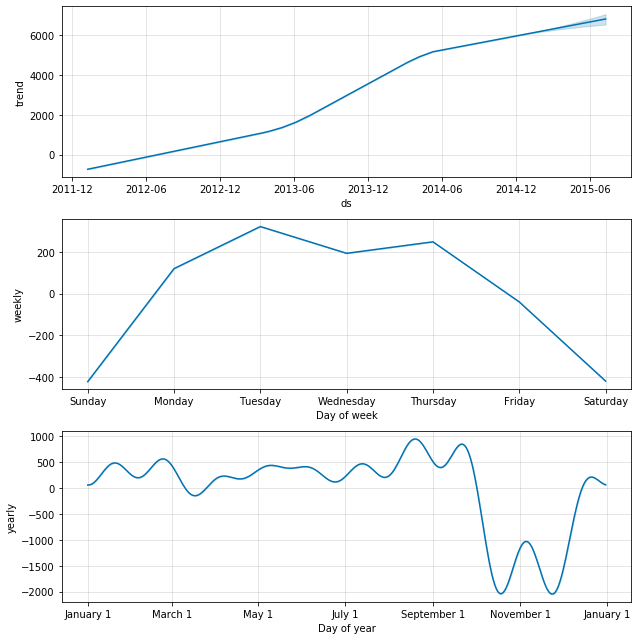

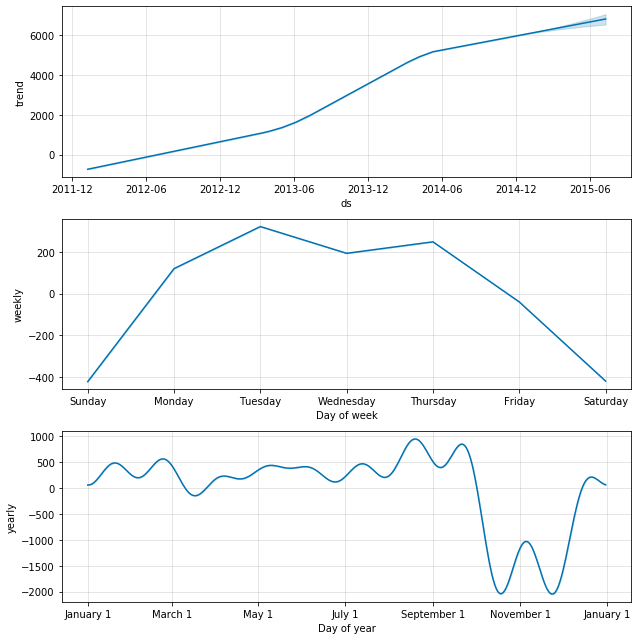

In [56]:
m.plot_components(forecast)

Using the mean hourly fraction for each hour from 0 to 23, we could then convert the daily forecasts into hourly forecasts make submission. This is how our forecasts over the daily data looks like.

In [59]:
forecast['Datetime'] = forecast['ds']

In [63]:
test

,ID,Datetime_x,hour_x,day,month,year,ds,trend,yhat_lower,yhat_upper,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Datetime_y,hour_y
0,18288,2014-09-26 00:00:00,0,26,9,2014,2014-09-26,5703.243027,3697.643834,9123.436818,...,-40.257263,680.158306,680.158306,680.158306,0.0,0.0,0.0,6343.144070,2014-09-26,0
1,18289,2014-09-26 01:00:00,1,26,9,2014,2014-09-26,5703.243027,3697.643834,9123.436818,...,-40.257263,680.158306,680.158306,680.158306,0.0,0.0,0.0,6343.144070,2014-09-26,0
2,18290,2014-09-26 02:00:00,2,26,9,2014,2014-09-26,5703.243027,3697.643834,9123.436818,...,-40.257263,680.158306,680.158306,680.158306,0.0,0.0,0.0,6343.144070,2014-09-26,0
3,18291,2014-09-26 03:00:00,3,26,9,2014,2014-09-26,5703.243027,3697.643834,9123.436818,...,-40.257263,680.158306,680.158306,680.158306,0.0,0.0,0.0,6343.144070,2014-09-26,0
4,18292,2014-09-26 04:00:00,4,26,9,2014,2014-09-26,5703.243027,3697.643834,9123.436818,...,-40.257263,680.158306,680.158306,680.158306,0.0,0.0,0.0,6343.144070,2014-09-26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5107,23395,2015-04-26 19:00:00,19,26,4,2015,2015-04-26,6522.179524,3418.088585,8951.286896,...,-423.533198,248.159716,248.159716,248.159716,0.0,0.0,0.0,6346.806041,2015-04-26,0
5108,23396,2015-04-26 20:00:00,20,26,4,2015,2015-04-26,6522.179524,3418.088585,8951.286896,...,-423.533198,248.159716,248.159716,248.159716,0.0,0.0,0.0,6346.806041,2015-04-26,0
5109,23397,2015-04-26 21:00:00,21,26,4,2015,2015-04-26,6522.179524,3418.088585,8951.286896,...,-423.533198,248.159716,248.159716,248.159716,0.0,0.0,0.0,6346.806041,2015-04-26,0
5110,23398,2015-04-26 22:00:00,22,26,4,2015,2015-04-26,6522.179524,3418.088585,8951.286896,...,-423.533198,248.159716,248.159716,248.159716,0.0,0.0,0.0,6346.806041,2015-04-26,0


In [65]:
# Extract hour, day, month and year from both dataframes to merge
for df in [test, forecast]:
    df['hour'] = df.Datetime.dt.hour
    df['day'] = df.Datetime.dt.day
    df['month'] = df.Datetime.dt.month
    df['year'] = df.Datetime.dt.year

# Merge forecasts with given IDs
test = pd.merge(test,forecast, on=['day','month','year'], how='left')
cols = ['ID','hour_x','yhat']
test_new = test[cols]

# Merging hourly average fraction to the test data
test_new = pd.merge(test_new, hourly_frac, left_on = ['hour'], right_index=True, how = 'left')
# Convert daily aggregate to hourly traffic
test_new['Count'] = test_new['yhat'] * test_new['fraction']
test_new.drop(['yhat','fraction','hour'],axis = 1, inplace = True)
test_new.to_csv('prophet_sub.csv',index = False)

AttributeError: 'DataFrame' object has no attribute 'Datetime'